# Linear algebra on n-dimensional arrays

use singular value decomposition to generate a compressed approximation of an image

https://numpy.org/doc/1.21/user/tutorial-svd.html

In [1]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

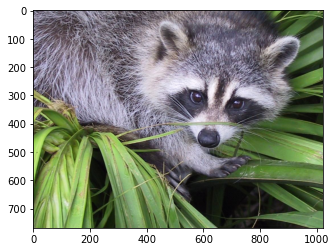

In [2]:
img = misc.face()
plt.imshow(img)

## Shape, axis, and array properties

In [3]:
img.shape

(768, 1024, 3)

In [4]:
img.ndim

3

access red channel

In [5]:
img[:, :, 0]

array([[121, 138, 153, ..., 119, 131, 139],
       [ 89, 110, 130, ..., 118, 134, 146],
       [ 73,  94, 115, ..., 117, 133, 144],
       ...,
       [ 87,  94, 107, ..., 120, 119, 119],
       [ 85,  95, 112, ..., 121, 120, 120],
       [ 85,  97, 111, ..., 120, 119, 118]], dtype=uint8)

change scale from 0-255 to 0-1

In [6]:
img_array = img / 255

check max and min

In [7]:
print(f"max = {img_array.max()}; min = {img_array.min()}")

max = 1.0; min = 0.0


check dtype

In [8]:
img_array.dtype

dtype('float64')

Color channels: 0=red, 1=green, 2=blue

## Operations on an axis

use SVD to rebuild an image with less info than the original one

note: using **linalg** module. Sometimes **scipy.linalg** is faster but only works with 2d arrays. 

In [9]:
from numpy import linalg

Given a matrix $A$, we're going to compute

$$
U \Sigma V^T = A
$$

- $U$, $V^T$ are squares, $\Sigma$ is the same size as $A$ and is a diagonal matrix with the singular values of A
- Singular values describe the importance of features

try on one matrix first: get grayscale image using
$$
Y = 0.2126R + 0.7152G + 0.0722B
$$

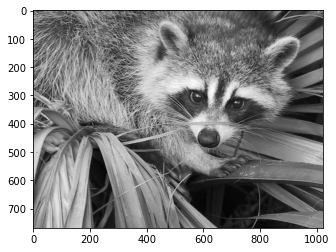

In [10]:
img_gray = img_array @ [0.2126, 0.7152, 0.0722]
plt.imshow(img_gray, cmap="gray")

In [11]:
img_gray.shape

(768, 1024)

now run svd

In [12]:
U, s, Vt = linalg.svd(img_gray)

In [13]:
print(f"U shape = {U.shape}; s shape = {s.shape}; Vt shape = {Vt.shape}")

U shape = (768, 768); s shape = (768,); Vt shape = (1024, 1024)


s and Vt can't be multiplied out of the box, since it's more efficient to store s as a 1d array

In [14]:
s@Vt

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1024 is different from 768)

generate diagonal matrix

In [15]:
Sigma = np.zeros((768, 1024))
for i in range(768):
  Sigma[i,i] = s[i]

## Approximation

use `norm` to calculate the quality of the approximation

In [16]:
linalg.norm(img_gray - U@Sigma@Vt)

1.4102987503620689e-12

can also use `allclose`

In [17]:
np.allclose(img_gray, U@Sigma@Vt)

True

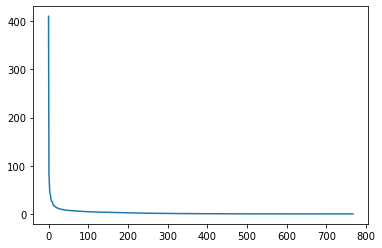

In [18]:
plt.plot(s)

Try considering all but the first k values in Sigma as 0, then computing the product (e.g. only reconstruct the image based on the first few most important features)

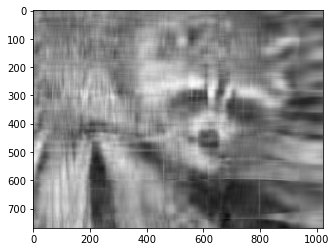

In [23]:
k = 10
approx = U @ Sigma[:, :k] @ Vt[:k, :]
plt.imshow(approx, cmap="gray")

## Applying to all colors

In [24]:
img_array.shape

(768, 1024, 3)

linalg functions expect (num matrices, M, M). i.e. reshape the image to (3, 768, 1024)

In [25]:
img_array_transposed = np.transpose(img_array, (2, 0, 1))
img_array_transposed.shape

(3, 768, 1024)

In [26]:
U, s, Vt = linalg.svd(img_array_transposed)
print(f"U shape = {U.shape}; s shape = {s.shape}; Vt shape = {Vt.shape}")

U shape = (3, 768, 768); s shape = (3, 768); Vt shape = (3, 1024, 1024)


## Products with n-dimensional arrays

np.dot, np.matmul, and @ work in very different ways for ndarrays (see docs for np.matmul)

buld sigma matrix- want (3, 768, 1024). Use each row in s as a diagonal for each channel

In [27]:
Sigma = np.zeros((3, 768, 1024))
for j in range(3):
  np.fill_diagonal(Sigma[j, :, :], s[j, :])

In [28]:
reconstructed = U@Sigma@Vt

In [29]:
reconstructed.shape

(3, 768, 1024)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


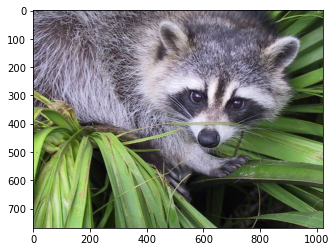

In [30]:
plt.imshow(np.transpose(reconstructed, (1, 2, 0)))

do approximation

In [34]:
k = 20
approx_img = U @ Sigma[..., :k] @ Vt[..., :k, :]
approx_img.shape

(3, 768, 1024)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


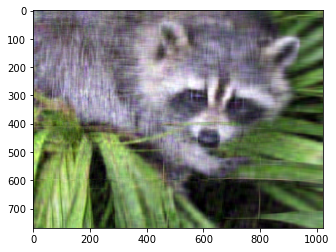

In [35]:
plt.imshow(np.transpose(approx_img, (1, 2, 0)))

## Final words

better algorithms exist (e.g. faster)- but this is the best approximation we can get to when considering the norm of the difference.